In the many physics disciplines we often deal with very noisy data for which we wish to infer probabilities of events or estimate some parameters. We like our answers with errorbars or even better yet full probability density functions (PDF's). And so might you btw, see this [excellent post on utility functions](http://www.sumsar.net/blog/2015/01/probable-points-and-credible-intervals-part-two/) by Rasmus Bååth on why you might also need them for better decision making. The rise in popularity in machine learning (ML) and artifical intelligence (AI) has not gone unnoticed in the natural sciences, see for example the Kaggle [Higgs Boson Machine Learning Challenge](https://www.kaggle.com/c/higgs-boson). 

In this blog post I will explain a problem we encounter in observational cosmology called photometric redshifts and how we can use Mixture Density Networks (MDN's) to solve them with an implementation in Tensor Flow. MDN was introduced by Bishop in the [following paper (PDF).](http://research.microsoft.com/en-us/um/people/cmbishop/downloads/Bishop-NCRG-94-004.pdf) 
The code used in this work is based on the [second](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/) of Itoro's comprehensive  blog posts on MDN's, the first that uses theano can be found [here](http://blog.otoro.net/2015/06/14/mixture-density-networks/). MDN's in the paper by Bishop and in Itoro's blog are applied to a toy problem trying to infer the position of a robotic arm. In this blog post I wanted to show the usage of MDN's on a real world problem, and with a real world problem I mean a simulated galaxy data set.

If you are a machine learning researcher or enthusiast I hope you can learn a bit about a challenging astronomy problem and maybe you can help me answer some ML question I have posed at the end of this blog. If you work with noisy data and/or  just  you want full PDF's I hope  you might be able to apply MDN's to your work.

This blog post is written in a jupyter notebook and the data used can be downloaded here.

## The photometric redshift problem:

In short, the photometric redshift problem is inverse problem with heteroscedastic noise properties. Hello ? Are you still here ? Great ! Heteroscedastic means that the noise properties of the data is not constant. Another way of saying this is that the variability of properties varies within the sample. The inverse part refers to the fact that there are more that one likely solution to the problem, hence the answer might be multimodal. 
We will refer to the distance of a galaxy as [redshift](https://en.wikipedia.org/wiki/Redshift).   

Due to nature of the galaxies and due to the noise properties it can happen that a galaxy that is close by (i.e low redshift) looks like a different kind of galaxy that is far away (i.e high redshift) and with the 5 magnitudes and their respective errors that we can measure we have no idea of knowing which it is. So we are interested in estimating the probability density function of the redshift for the galaxies and using mixture density networks is one possible way of doing so.  

You might be wondering why we need the distances to the galaxies, in my case it to measure the accelerated expansion of the universe a.k.a Dark Energy, and to be more exact I would like to infer the redshift distribution of an ensemble of galaxies. Other astronomer might want to use it other purposes.

The redshift of a galaxy can be  measured exactly with a spectrograph. A spectrograph will detect emission lines in the spectrum of the galaxy that allows to precisely determine the redshift of the galaxy. The problem with spectrographs is that the use is expensive in time, meaning you can not observe massive amount of galaxies with them. 
To be able to measure the properties of massive amount of galaxies (100 million+) we perform photometric surveys, these use massive CCD cameras to take images of the sky in several filters. In the following image, the blue, green and red line is the spectrum of a galaxy a different redshifts. With a spectrograph one can measure exact details and hence the redshift. The 5 grey areas on bottom are the filter response curves used in photometric surveys. This means that in the photometric survey we measure 5 values, one for each of the filters. The measurement are referred to as magnitudes (which happens to be the negative of a log transform of the flux thus high magnitude means a faint galaxy).  
As you can see the detailed information of the spectrum of galaxies is lost when using the photometric information, the advantage is that we can observe many more galaxies. But now the problem is that we have to infer the redshift of the galaxies with just those 5 numbers, and as you probably can see from the image, it's not going to be easy.
![Alt Text](./images/plot_sdss_filters_2.png)
This image is taken from the [astroML](http://www.astroml.org/#astroml-machine-learning-and-data-mining-for-astronomy) page that accompanies the excellent book: [Statistics, Data Mining, and Machine Learning in Astronomy](http://www.astroml.org/#textbook)

To make things more complicated the noise levels in the data sets differ quite significantly, this can be due to that some parts of the sky have been observed with longer exposure times, but even for galaxies with the same amount of exposure time the noise levels will differ based on the size of the galaxy or the amount of turbulence in the atmosphere while observing. The good news is that for each of the 5 magnitudes (i.e features) we can also estimate the noise of this measurement, this leaves us with 5 measured magnitudes accompanied with error bars totalling to 10 features (we are assuming the noise is not correlated which is a simplification).

Just to recap, from a machine learning standpoint we have the following problem, we have a large data set for which  we have measured 5 magnitudes and their respective errors, a subset of these galaxies have also been observed with a spectrograph and hence we know the exact redshift. We want to predict the redshift, so we have a regression  problem, but we are not just interested in the most likely redshift but in the full PDF.

## Mixture Density Networks

This is where MDN's come in, MDN's are very similar to standard Neural Networks with the only difference being that final layer is mapped to a mixture of  distributions. This makes them an elegant solution for modeling arbitrary conditional probability distributions like we have here. 
In our case : $$ p(z \hspace{1mm} | \hspace{1mm} x) = \sum_{k=1}^{K} \pi_k(x) Beta(z |\alpha_k(x), \beta_{k}(x))$$,
where z is redshift and x are the measured features with their corresponding errors. 
So the output of a MDN is $k$ mixture components and the parameters for each of the $k$ distributions. In our case we will be using a mixture of $Beta$ distributions as it suits the purpose of our problem. 
Here is a little recap on what shape the beta distribution can take.

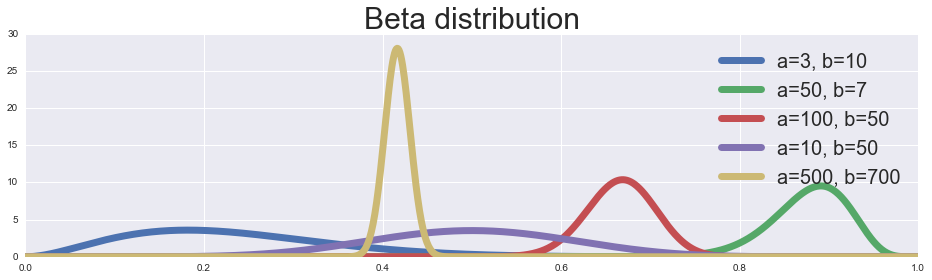

In [23]:
%matplotlib inline
from __future__ import division
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

x = np.linspace(0.0,1.0, 1000)
b0 = beta.pdf(x, 3 , 10)
b1 = beta.pdf(x, 50 , 7)
b2 = beta.pdf(x, 100 , 50)
b3 = beta.pdf(x, 10 , 10)
b4 = beta.pdf(x, 500 , 700)
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, b0, label='a=3, b=10', lw=7)
plt.plot(x, b1, label='a=50, b=7' ,lw=7)
plt.plot(x, b2, label='a=100, b=50', lw=7)
plt.plot(x, b3, label='a=10, b=50', lw=7)
plt.plot(x, b4, label='a=500, b=700', lw=7)
plt.legend(fontsize=20)
plt.title('Beta distribution', fontsize=30)

In this blog post we will use a simulated galaxy data set. This data set contains galaxies that have been simulated with 5 different exposures times, ranging from very high signal to noise (S/N) to very low S/N. Keep in mind, as mentioned earlier, even within a fixed exposure time we have varying noise levels. A training sample has already been created with 30000 galaxies fairly sampled galaxies for each exposure time leading to a total of 150000 galaxies in the training set. The validation set contains 200000 galaxies and we have the 5 exposure levels for each of those galaxies so we can look at the influence of the noise on the prediction. Let's read in the data and explore the data set. In astronomy is the convention that mesured magnitudes have a letter as a name, in this case we have $g,r,i,z,Y$ as the 5 measured magnitudes.  

## The data set

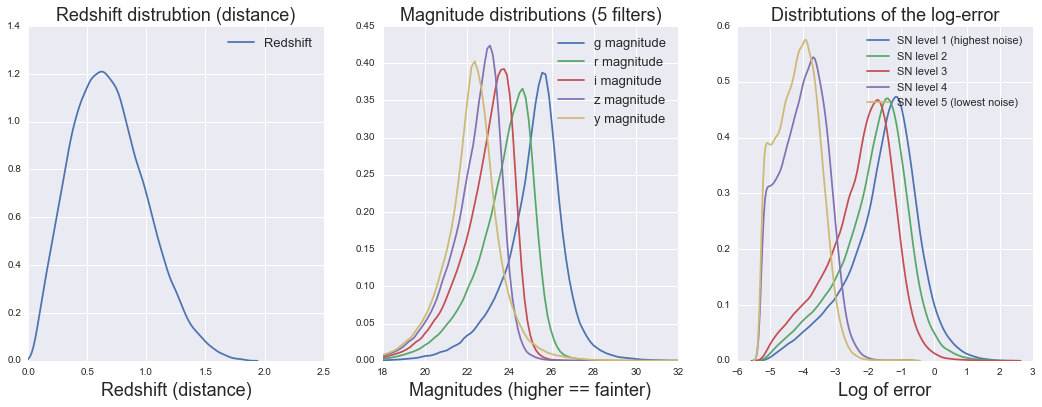

In [33]:
import pandas as pd
df_train = pd.read_csv('./data/galaxy_redshift_sims_train.csv', 
                       engine='c', na_filter=False, nrows=1000) 
df_valid = pd.read_csv('./data/galaxy_redshift_sims_valid.csv', 
                       engine='c', na_filter=False, nrows=100000)
df_valid = df_valid[(df_valid.redshift < df_train.redshift.max()) & 
                    (df_valid.redshift > df_train.redshift.min())]
# need to make sure that this last line is not needed

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.distplot(df_valid.redshift, kde=True, ax=axes[0], hist=False, label='Redshift')
axes[0].set_xlim([0, 2.5])
axes[0].set_title('Redshift distrubtion (distance)', fontsize=18)
axes[0].legend(fontsize=13)
axes[0].set_xlabel('Redshift (distance)', fontsize=18)

sns.distplot(df_valid.g_SN_1, kde=True,ax=axes[1], hist=False, label='g magnitude')
sns.distplot(df_valid.r_SN_1, kde=True,ax=axes[1], hist=False, label='r magnitude')
sns.distplot(df_valid.i_SN_1, kde=True,ax=axes[1], hist=False, label='i magnitude')
sns.distplot(df_valid.z_SN_1, kde=True,ax=axes[1], hist=False, label='z magnitude')
sns.distplot(df_valid.y_SN_1, kde=True,ax=axes[1], hist=False, label='y magnitude')
axes[1].set_xlim([18, 32])
axes[1].set_title('Magnitude distributions (5 filters)', fontsize=18)
axes[1].legend(fontsize=13)
axes[1].set_xlabel('Magnitudes (higher == fainter)', fontsize=18)

sns.distplot(df_valid.log_g_err_SN_1, kde=True,ax=axes[2], hist=False, 
             label='SN level 1 (highest noise)')
sns.distplot(df_valid.log_g_err_SN_2, kde=True,ax=axes[2], hist=False, 
             label='SN level 2')
sns.distplot(df_valid.log_g_err_SN_3, kde=True,ax=axes[2], hist=False, 
             label='SN level 3')
sns.distplot(df_valid.log_g_err_SN_4, kde=True,ax=axes[2], hist=False, 
             label='SN level 4')
sns.distplot(df_valid.log_g_err_SN_5, kde=True,ax=axes[2], hist=False, 
             label='SN level 5 (lowest noise)')
axes[2].set_xlim([-6, 3])
axes[2].set_title('Distribtutions of the log-error', fontsize=18)
axes[2].legend(fontsize=11)
axes[2].set_xlabel('Log of error', fontsize=18)

In [34]:
df_train.head()

,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err,redshift,log_g_err,log_r_err,log_i_err,log_z_err,log_y_err
0,22.561269,0.030931,20.784303,0.014176,19.952773,0.012864,19.536000,0.012374,19.335426,0.031846,0.5249,-3.475996,-4.256205,-4.353323,-4.392158,-4.392158
1,25.392476,0.212410,23.596781,0.090048,22.407283,0.051218,22.044526,0.073657,21.958519,0.287072,0.5844,-1.549237,-2.407412,-2.971664,-2.608336,-2.608336
2,23.455420,0.046455,21.957914,0.021684,21.527561,0.031701,21.105837,0.040076,21.078874,0.127973,0.4632,-3.069271,-3.831181,-3.451407,-3.216978,-3.216978
3,25.472922,0.289218,23.886281,0.092148,22.917807,0.090538,22.638243,0.123078,22.153964,0.312088,0.5558,-1.240575,-2.384359,-2.401986,-2.094937,-2.094937
4,23.598560,0.063078,22.290325,0.027985,21.883217,0.041042,21.607525,0.049119,21.211616,0.182087,0.4179,-2.763383,-3.576087,-3.193159,-3.013509,-3.013509


In [36]:
### In the validation set we have the 5 SN levels for each galaxy ###
df_valid.head()

,id,redshift,g_true,r_true,i_true,z_true,y_true,g_SN_5,g_err_SN_5,r_SN_5,...,log_g_err_SN_4,log_r_err_SN_4,log_i_err_SN_4,log_z_err_SN_4,log_y_err_SN_4,log_g_err_SN_5,log_r_err_SN_5,log_i_err_SN_5,log_z_err_SN_5,log_y_err_SN_5
0,1296052,0.4257,25.706,23.999,23.424,23.052,22.915,25.714726,0.023859,24.000923,...,-3.710634,-4.264421,-4.522025,-4.693892,-4.693892,-3.735594,-4.822456,-4.946112,-5.003411,-5.003411
1,522044,0.4798,24.595,22.802,22.065,21.670,21.518,24.595868,0.009302,22.801899,...,-4.369229,-4.722941,-4.964277,-5.076294,-5.076294,-4.677526,-5.146283,-5.192697,-5.196122,-5.196122
2,1596357,0.4903,26.480,24.917,24.318,23.984,23.845,26.483449,0.034660,24.907106,...,-2.836799,-3.500476,-3.938418,-4.122004,-4.122004,-3.362169,-4.370098,-4.518626,-4.618661,-4.618661
3,993122,0.2738,21.122,19.920,19.507,19.209,19.080,21.122545,0.005330,19.919980,...,-5.203735,-5.210673,-5.256216,-5.268370,-5.268370,-5.234404,-5.280085,-5.283035,-5.287377,-5.287377
4,1655575,0.9341,26.041,25.084,24.051,23.518,23.396,26.026716,0.020367,25.077148,...,-3.376407,-3.025017,-4.206797,-4.413971,-4.413971,-3.893839,-4.252122,-4.833703,-4.913463,-4.913463


The above plots and DataFrame heads should give you some idea on what the data set looks like. Lets extract the features and scale the parameters. Given that we are using  noisy data we will use the RobustScaler in scikit-learn which is always advisable if you are dealing with noisy data.

In [41]:
from sklearn.preprocessing import RobustScaler
RS = RobustScaler()

### The training features ### 
feat_train = ['g', 'log_g_err', 'r', 'log_r_err', 'i', 'log_i_err',
              'z', 'log_z_err', 'y', 'log_y_err']

### the features for the validation set, each galaxy has 5 distinct features ###
### 1 for each exposer time ###
feat_SN_1 = ['g_SN_1', 'log_g_err_SN_1', 'r_SN_1', 'log_r_err_SN_1',
             'i_SN_1', 'log_i_err_SN_1', 'z_SN_1', 'log_z_err_SN_1',
             'y_SN_1', 'log_y_err_SN_1']

feat_SN_2 = ['g_SN_2', 'log_g_err_SN_2', 'r_SN_2', 'log_r_err_SN_2',
             'i_SN_2', 'log_i_err_SN_2', 'z_SN_2', 'log_z_err_SN_2',
             'y_SN_2', 'log_y_err_SN_2']

feat_SN_3 = ['g_SN_3', 'log_g_err_SN_3', 'r_SN_3', 'log_r_err_SN_3',
             'i_SN_3', 'log_i_err_SN_3', 'z_SN_3', 'log_z_err_SN_3',
             'y_SN_3', 'log_y_err_SN_3']

feat_SN_4 = ['g_SN_4', 'log_g_err_SN_4', 'r_SN_4', 'log_r_err_SN_4',
             'i_SN_4', 'log_i_err_SN_4', 'z_SN_4', 'log_z_err_SN_4',
             'y_SN_4', 'log_y_err_SN_4']

feat_SN_5 = ['g_SN_5', 'log_g_err_SN_5', 'r_SN_5', 'log_r_err_SN_5',
             'i_SN_5', 'log_i_err_SN_5', 'z_SN_5', 'log_z_err_SN_5',
             'y_SN_5', 'log_y_err_SN_5']

###  training features with robust scaler ###
X_train = RS.fit_transform(df_train[feat_train])

### validation features in different noise levels ###
X_valid_SN_1 = RS.transform(df_valid[feat_SN_1])
X_valid_SN_2 = RS.transform(df_valid[feat_SN_2])
X_valid_SN_3 = RS.transform(df_valid[feat_SN_3])
X_valid_SN_4 = RS.transform(df_valid[feat_SN_4])
X_valid_SN_5 = RS.transform(df_valid[feat_SN_5])

### The targets that we wish to learn ###
Y_train = df_train['redshift']
Y_valid = df_valid['redshift']

### Some scaling of the target between 0 and 1 so we can model it with a beta function ###
### given that Beta function is not defined at 0 or 1 I've come up with this ulgy hack ###
max_train_Y = Y_train.max() + 0.00001
min_train_Y = Y_train.min() - 0.00001

### scaling : 0 < target < 1 ###
Y_train = (Y_train - min_train_Y) / (max_train_Y - min_train_Y)
Y_valid = (Y_valid - min_train_Y) / (max_train_Y - min_train_Y)

Y_train = Y_train[:, np.newaxis]  # add extra axis as tensorflow expects this 
Y_valid = Y_valid[:, np.newaxis] 

For the validation set we also have the true magnitudes and not just the noisy draws, this allows us to make a 'artificial' validation set where we set the magnitude to the true one but keep the errors.

In [45]:
### we will make a third test set ###
### where magnitudes are set to the  ###
### true value but we change the noise ###

feat_SN_1_artific = ['g_true', 'log_g_err_SN_1', 'r_true', 'log_r_err_SN_1',
                     'i_true', 'log_i_err_SN_1', 'z_true', 'log_z_err_SN_1',
                     'y_true', 'log_y_err_SN_1']

feat_SN_2_artific = ['g_true', 'log_g_err_SN_2', 'r_true', 'log_r_err_SN_2',
                     'i_true', 'log_i_err_SN_2', 'z_true', 'log_z_err_SN_2',
                     'y_true', 'log_y_err_SN_2']

feat_SN_3_artific = ['g_true', 'log_g_err_SN_3', 'r_true', 'log_r_err_SN_3',
                     'i_true', 'log_i_err_SN_3', 'z_true', 'log_z_err_SN_3',
                     'y_true', 'log_y_err_SN_3']

feat_SN_4_artific = ['g_true', 'log_g_err_SN_3', 'r_true', 'log_r_err_SN_3',
                     'i_true', 'log_i_err_SN_3', 'z_true', 'log_z_err_SN_3',
                     'y_true', 'log_y_err_SN_3']

feat_SN_5_artific = ['g_true', 'log_g_err_SN_3', 'r_true', 'log_r_err_SN_3',
                     'i_true', 'log_i_err_SN_3', 'z_true', 'log_z_err_SN_3',
                     'y_true', 'log_y_err_SN_3']

### validation features in different noise levels ###
X_valid_SN_1_artific = RS.transform(df_valid[feat_SN_1_artific])
X_valid_SN_2_artific = RS.transform(df_valid[feat_SN_2_artific])
X_valid_SN_3_artific = RS.transform(df_valid[feat_SN_3_artific])
X_valid_SN_4_artific = RS.transform(df_valid[feat_SN_4_artific])
X_valid_SN_5_artific = RS.transform(df_valid[feat_SN_5_artific])

## MDN's in TensorFlow

In the next code block we will start building the MDN. We will model the PDF of a galaxy as a mixture 5 $Beta$ distributions. The neural network will figure out how many it actually needs and set the mixture components of the other close to zero, so adding extra complexity should not punish your predictive power, but you might of course be wasting computational resources. The neural network that will be building will be a rather simple one, we are trying to learn a distribution, not translate Klingon to Elvish trained on screenshots and luck. We will make neural network with 3 hidden layers with 10 neurons in each layer. We will use a ReLU activation function and no dropout regularization just some old-fashioned L2 regularization. I comment further on these choices at the end the blog.

In [43]:
import tensorflow as tf
STDEV = 0.10
KMIX = 5  # number of mixtures
NOUT = KMIX * 3  # pi, alpa , beta

n_hidden_1 = 10  # 1st layer num neurons
n_hidden_2 = 10  # 2nd layer num neurons
n_hidden_3 = 10  # 2nd layer num neurons

# place holders
weight_decay = tf.placeholder(dtype=tf.float32, name="wd")
x = tf.placeholder(dtype=tf.float32, shape=[None, 10], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="y")

# hidden layer one 
Wh = tf.Variable(tf.random_normal([10, n_hidden_1], stddev=STDEV, dtype=tf.float32))
bh = tf.Variable(tf.random_normal([1, n_hidden_1], stddev=STDEV, dtype=tf.float32))

# hidden layer two 
Wh2 = tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=STDEV, dtype=tf.float32))
bh2 = tf.Variable(tf.random_normal([1, n_hidden_2], stddev=STDEV, dtype=tf.float32))

# hidden layer three
Wh3 = tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], stddev=STDEV, dtype=tf.float32))
bh3 = tf.Variable(tf.random_normal([1, n_hidden_3], stddev=STDEV, dtype=tf.float32))

# output layer
Wo = tf.Variable(tf.random_normal([n_hidden_3,NOUT], stddev=STDEV, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1, NOUT], stddev=STDEV, dtype=tf.float32))

# tanh acitivation function
# hidden_layer1 = tf.nn.tanh(tf.add(tf.matmul(x, Wh), bh))
# hidden_layer2 = tf.nn.tanh(tf.add(tf.matmul(hidden_layer1, Wh2),bh2))
# hidden_layer3 = tf.nn.tanh(tf.add(tf.matmul(hidden_layer2, Wh3),bh3))

# ReLU acitivation function
hidden_layer1 = tf.nn.relu(tf.add(tf.matmul(x, Wh), bh))
hidden_layer2 = tf.nn.relu(tf.add(tf.matmul(hidden_layer1, Wh2),bh2))
hidden_layer3 = tf.nn.relu(tf.add(tf.matmul(hidden_layer2, Wh3),bh3))

output = tf.matmul(hidden_layer3, Wo) + bo

The parameters we want to predict are $k$ mixture components $\pi$ and the $\alpha$ and $\beta$ shape parameters for  each of the $Beta$ distributions. All three are subject to their constraints :   

$$\sum_{n=1}^{k} \pi_{n} = 1 $$
$$\alpha, \beta > 0$$  

In the function in the following code block we transform the neurons of the final layer into the factors we can interpret as our parameters of interest. The first five outputs are mapped to the 5 mixing weights $\pi$ by putting them through a softmax transformation, this ensures they are positive and add to one, while the next five are mapped to the $\alpha's$ and the last five to the $\beta's$ and by taking the exponential of those we can guarantee that they are positive as required.
Below is a schematic where the output is mapped to two $Beta$ distributions.

![ALt Text](./images/MDN_drawing_small.png)

In [46]:
def get_mixture_coef(output):
    ### Mapping output layer to mixute componets and 
    ### parameters of the distrution
    out_pi = tf.placeholder(dtype=tf.float32, shape=[None, KMIX], name="mixparam")
    out_alpha = tf.placeholder(dtype=tf.float32, shape=[None, KMIX], name="mixparam")
    out_beta = tf.placeholder(dtype=tf.float32, shape=[None, KMIX], name="mixparam")

    out_pi, out_alpha, out_beta = tf.split(1, 3, output)

    max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
    out_pi = tf.sub(out_pi, max_pi)
    out_pi = tf.exp(out_pi)

    normalize_pi = tf.inv(tf.reduce_sum(out_pi, 1, keep_dims=True))
    out_pi = tf.mul(normalize_pi, out_pi)

    out_alpha = tf.exp(out_alpha)
    out_beta = tf.exp(out_beta)

    return out_pi, out_alpha, out_beta
out_pi, out_alpha, out_beta = get_mixture_coef(output) 

To be able to use of mixture of $Beta$ distributions we will have to implement the $Beta$ distribution in Tensor Flow and to do so we will need the $Gamma$ distribution or log-gamma to be more precise. A fast approximation to the log-gamma fuction can be found on [Paul Mineiro's blog](http://www.machinedlearnings.com/2011/06/faster-lda.html), with which we can build the $Beta$ distribution.

In [14]:
def gammaln(x):
    # fast approximate gammaln from Paul Mineiro
    # http://www.machinedlearnings.com/2011/06/faster-lda.html
    logterm = tf.log (x * (1.0 + x) * (2.0 + x))
    xp3 = 3.0 + x
    return -2.081061466 - x + 0.0833333 / xp3 - logterm + (2.5 + x) * tf.log (xp3)

def tf_beta_dist(y, s1, s2):
    # beta distribtuion for tensorflow 
    exp1 = tf.sub(s1, 1.0)
    exp2 = tf.sub(s2, 1.0)
    d1 = tf.mul(exp1, tf.log(y))
    d2 = tf.mul(exp2, tf.log(tf.sub(1.0, y)))
    f1 = tf.add(d1, d2)
    f2 = gammaln(s1)      
    f3 = gammaln(s2)      
    f4 = gammaln(s1 + s2) 
    return  tf.exp(tf.add((tf.sub(f4, tf.add(f2, f3))),f1))

Having defined the $Beta distribution$ we can now define our loss function after which we will be ready to train the network. For regression problems ones usually minimize the squared error (L2 loss function), in this case however it makes more sense to minimize the negative $log$ likelihood of the data.

In the case of homoscedastic errors it doesn't make much sense to feed the error as a features as it the same for all
examples. In the case for heteroscedastic errors the error estimate actually contains some information of the target, but I expect the information to be of minimal importance compared to the measured feature. We can do perform the following experiment :
Imagine a pathological case where you happen to observe the same galaxy at different noise levels, but magnitude you measure is always the same. The most likely redshift for all these cases should be very similar, it is the certainty of how well we know this redshift that will differ to greater degree. we be able to see if that is true later on.
When you minimize the negative log-likelihood (or the cross-entropy) it makes sense to add the estimate of the noise as it contains the information on the uncertainty.

In [15]:
def get_lossfunc(out_pi, out_alpha, out_beta, y, Wh, Wh2, Wo, weight_decay=5e-4):
    ### neg log likelihood 
    result = tf_beta_dist(y, out_alpha, out_beta)
    result = tf.mul(result, out_pi)
    result = tf.reduce_sum(result, 1, keep_dims=True)
    result = -tf.log(result)
    regularizers = (tf.nn.l2_loss(Wh) + tf.nn.l2_loss(Wh2) + tf.nn.l2_loss(Wo)
                    +tf.nn.l2_loss(bh) + tf.nn.l2_loss(bh2) + tf.nn.l2_loss(bo))
    return tf.reduce_mean(result) + (weight_decay * regularizers)   

## Training the MDN
We are now ready to train the network on our data, let's take it for a spin

In [16]:
NEPOCH = 100
weight_decay_value = 0.001
# with tf.device('/cpu:0'):
lossfunc = get_lossfunc(out_pi, out_alpha, out_beta, y, Wh, Wh2, Wo)
train_op = tf.train.AdamOptimizer().minimize(lossfunc)
sess = tf.Session()
sess.run(tf.initialize_all_variables()) 

loss_train   = np.zeros(NEPOCH) # store the training progress here.
loss_valid_1 = np.zeros(NEPOCH)
loss_valid_2 = np.zeros(NEPOCH)
loss_valid_3 = np.zeros(NEPOCH)
loss_valid_4 = np.zeros(NEPOCH)
loss_valid_5 = np.zeros(NEPOCH)

for i in range(NEPOCH):
    sess.run(train_op, feed_dict={x: X_train, y: Y_train, weight_decay: weight_decay_value})

    loss_train[i] = sess.run(lossfunc, feed_dict={x: X_train,
                                                  y: Y_train,
                                                  weight_decay : weight_decay_value})

    loss_valid_1[i] = sess.run(lossfunc, feed_dict={x: X_valid_SN_1,
                                                  y: Y_valid,
                                                  weight_decay : weight_decay_value})

    loss_valid_2[i] = sess.run(lossfunc, feed_dict={x: X_valid_SN_2,
                                                    y: Y_valid,
                                                    weight_decay : weight_decay_value})

    loss_valid_3[i] = sess.run(lossfunc, feed_dict={x: X_valid_SN_3,
                                                    y: Y_valid,
                                                    weight_decay : weight_decay_value})

    loss_valid_4[i] = sess.run(lossfunc, feed_dict={x: X_valid_SN_4,
                                                    y: Y_valid,
                                                    weight_decay : weight_decay_value})

    loss_valid_5[i] = sess.run(lossfunc, feed_dict={x: X_valid_SN_5,
                                                    y: Y_valid,
                                                    weight_decay : weight_decay_value})
    
pi_1,alpha_1, beta_1 = sess.run(get_mixture_coef(output), feed_dict={x: X_valid_SN_1})
pi_2,alpha_2, beta_2 = sess.run(get_mixture_coef(output), feed_dict={x: X_valid_SN_2})
pi_3,alpha_3, beta_3 = sess.run(get_mixture_coef(output), feed_dict={x: X_valid_SN_3})
pi_4,alpha_4, beta_4 = sess.run(get_mixture_coef(output), feed_dict={x: X_valid_SN_4})
pi_5,alpha_5, beta_5 = sess.run(get_mixture_coef(output), feed_dict={x: X_valid_SN_5})

pi_1_a, alpha_1_a, beta_1_a = sess.run(get_mixture_coef(output), feed_dict={x: X_valid_SN_1_artific})
pi_2_a, alpha_2_a, beta_2_a = sess.run(get_mixture_coef(output), feed_dict={x: X_valid_SN_2_artific})
pi_3_a, alpha_3_a, beta_3_a = sess.run(get_mixture_coef(output), feed_dict={x: X_valid_SN_3_artific})
pi_4_a, alpha_4_a, beta_4_a = sess.run(get_mixture_coef(output), feed_dict={x: X_valid_SN_4_artific})
pi_5_a, alpha_5_a, beta_5_a = sess.run(get_mixture_coef(output), feed_dict={x: X_valid_SN_5_artific})

sess.close()

TypeError: unsupported operand type(s) for /: 'float' and 'Tensor'

We can see how the loss has evolved as function of time for 5 differenr signal to noise levels

In [17]:
plt.figure(figsize=(16, 7))
plt.plot(np.arange(0, NEPOCH,1), (loss_train), label='Train')
plt.plot(np.arange(0, NEPOCH,1), (loss_valid_1), label='Valid_1')
plt.plot(np.arange(0, NEPOCH,1), (loss_valid_2), label='Valid_2')
plt.plot(np.arange(0, NEPOCH,1), (loss_valid_3), label='Valid_3')
plt.plot(np.arange(0, NEPOCH,1), (loss_valid_4), label='Valid_4')
plt.plot(np.arange(0, NEPOCH,1), (loss_valid_5), label='Valid_5')
plt.legend()

NameError: name 'loss_train' is not defined

## Results
Let see how the mixture models performs for the same galaxy. I expect the noisiest to have the broadest PDF.

NameError: name 'plot_beta_mix' is not defined

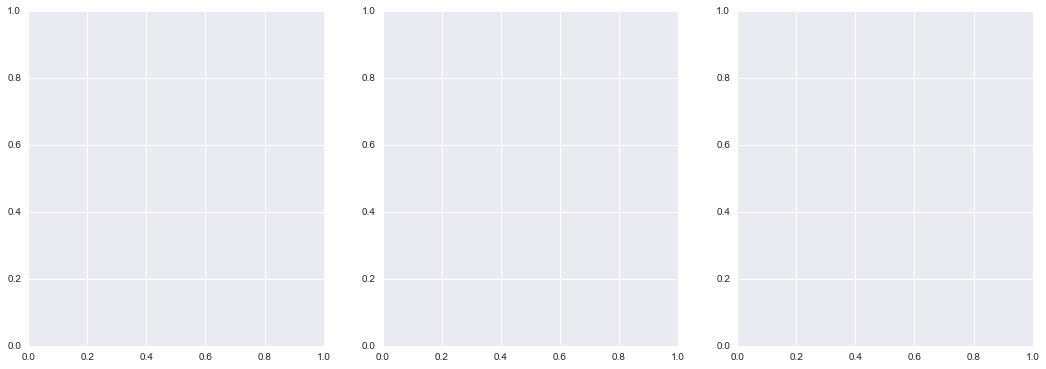

In [19]:
gal_id = 173
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
plot_beta_mix(pi_1[gal_id], alpha_1[gal_id], beta_1[gal_id], axes[0])
plot_beta_mix(pi_2[gal_id], alpha_2[gal_id], beta_2[gal_id], axes[1])
plot_beta_mix(pi_3[gal_id], alpha_3[gal_id], beta_3[gal_id], axes[2])

This indeed does seem to be the case. In the test data set where we kept the truth magnitudes for all noise levels my expectation is that the mean of  the distributions are good agreement but that the width differs. This due to fact that to first order the most likely location of the galaxy is determined by the magnitudes, and these are exactly the same in this case, and the the width differs. This version is just a more controlled setting of the above experiment as we do not rely on a random draw.

NameError: name 'plot_beta_mix' is not defined

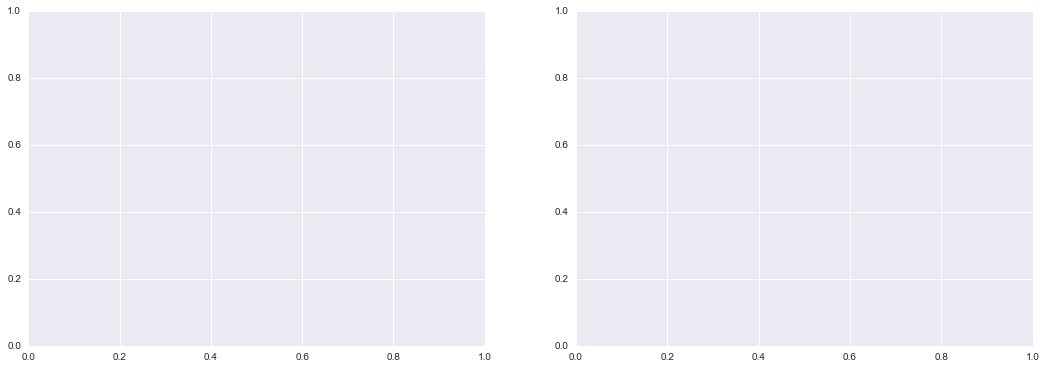

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
gal_id = 999

plot_beta_mix(pi_1_a[gal_id], alpha_1_a[gal_id], beta_1_a[gal_id], axes[0], comp=False, label='SN-1')
plot_beta_mix(pi_2_a[gal_id], alpha_2_a[gal_id], beta_2_a[gal_id], axes[0], comp=False, label='SN-2')
plot_beta_mix(pi_3_a[gal_id], alpha_3_a[gal_id], beta_3_a[gal_id], axes[0], comp=False, label='SN-3')

gal_id = 10

plot_beta_mix(pi_1_a[gal_id], alpha_1_a[gal_id], beta_1_a[gal_id], axes[1], comp=False, label='SN-1')
plot_beta_mix(pi_2_a[gal_id], alpha_2_a[gal_id], beta_2_a[gal_id], axes[1], comp=False, label='SN-2')
plot_beta_mix(pi_3_a[gal_id], alpha_3_a[gal_id], beta_3_a[gal_id], axes[1], comp=False, label='SN-3')

As you can see, it's not quite what I expected. I can't be sure what the reason is, the fact that the error does  carry some information of the distance of the galaxy probably has something to do with it. In the next cell we will transform the output of the MDN into a pandas dataframe for better viewing and while we are at it we will calculate some useful statistics of the PDF. 

Some advantage of using MDN's over say softmax regression are the following: 
1. The PDF information is contained in 15 numbers per galaxy, If I was doing softmax regression this would depend on the chosen binning. In my case this can be anywhere from 80 to 200 bins, hence using MDN's leads to more efficient data storage, keep in mind we will need this for up to half a billion galaxies. 
2. Some statistics of the PDF can be calculated analytically for the mixture, as we do here for the mean and variance. I don't think this is possible for the mode or entropy. This is useful as we want to select the galaxies in redshift bins and selecting on the mean is one way of doing this.
The mean of the PDF is what we would have gotten if we had minimized the L2 loss functions, if the distribution is multimodal this is of limited use.

In [71]:
res_1_df = return_df(pi_1, alpha_1, beta_1, Y_valid)
res_2_df = return_df(pi_2, alpha_2, beta_2, Y_valid)
res_3_df = return_df(pi_3, alpha_3, beta_3, Y_valid)
res_4_df = return_df(pi_4, alpha_4, beta_4, Y_valid)
res_5_df = return_df(pi_5, alpha_5, beta_5, Y_valid)

res_1_df_a = return_df(pi_1_a, alpha_1_a, beta_1_a, Y_valid)
res_2_df_a = return_df(pi_2_a, alpha_2_a, beta_2_a, Y_valid)
res_3_df_a = return_df(pi_3_a, alpha_3_a, beta_3_a, Y_valid)
res_4_df_a = return_df(pi_4_a, alpha_4_a, beta_4_a, Y_valid)
res_5_df_a = return_df(pi_5_a, alpha_5_a, beta_5_a, Y_valid)

In [72]:
res_2_df.sort_values(by='variance',ascending=False).head()

,pi_0,pi_1,pi_2,alpha_0,alpha_1,alpha_2,beta_0,beta_1,beta_2,mean,variance,stddev,redshift
7639,0.483435,0.016382,0.500183,4.552222,1.671589,4.389098,3.036347,0.337221,11.996679,0.437613,0.035422,0.188206,0.741908
5477,0.460064,0.012173,0.527762,4.761754,1.817648,5.132354,3.602483,0.333750,13.352030,0.418737,0.026493,0.162766,0.468419
98,0.451681,0.013676,0.534643,4.347667,1.715218,4.629306,3.672609,0.341888,12.448475,0.401179,0.024855,0.157655,0.668966
6366,0.286524,0.016625,0.696851,2.271285,1.319140,2.499490,3.032468,0.453017,12.587393,0.250526,0.024334,0.155992,0.793462
2035,0.483940,0.005656,0.510404,6.866736,2.131763,8.653544,4.951657,0.262686,20.749512,0.436431,0.023160,0.152184,0.474726


Let's have a look if we have managed to learn what we intended to learn. Just to recap, we wanted to learn the distributions of an ensemble go galaxies. 
The plots below show the estimate distribution in 3 redshift bins by selecting galaxies on the mean. 
The MDN is obtained by stacking the PDF's (dotted line) and the truth is KDE estimate of the true redshifts. 

NameError: name 'res_1_df' is not defined

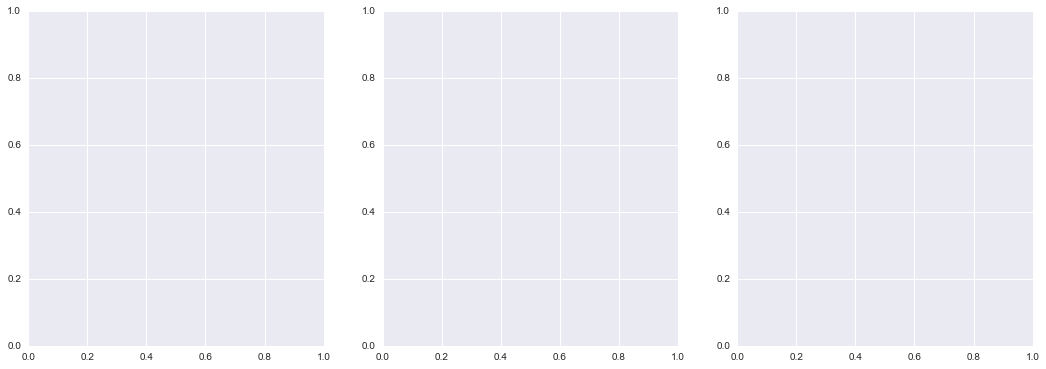

In [47]:
### Keep in mind that the data is mapped on to the domain (0,1)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

plot_ensemble(res_1_df, ax=axes[0], redshift_sel=(0.1, 0.2))
plot_ensemble(res_1_df, ax=axes[0], redshift_sel=(0.3, 0.5))
plot_ensemble(res_1_df, ax=axes[0], redshift_sel=(0.6, 1.0))

plot_ensemble(res_2_df, ax=axes[1], redshift_sel=(0.1, 0.2))
plot_ensemble(res_2_df, ax=axes[1], redshift_sel=(0.3, 0.5))
plot_ensemble(res_2_df, ax=axes[1], redshift_sel=(0.6, 1.0))

plot_ensemble(res_3_df, ax=axes[2], redshift_sel=(0.1, 0.2))
plot_ensemble(res_3_df, ax=axes[2], redshift_sel=(0.3, 0.5))
plot_ensemble(res_3_df, ax=axes[2], redshift_sel=(0.6, 1.0))

## Is that all there is too it ? 
It seems that the MDN did a pretty good job, Hooray !
You might be wondering if this is realistic ? Let me give you some insight into further complications.  
In reality the training set is not unbiased sample of the set you are interested in, this is true in 3 different ways. 
1. We are dealing with a co-variate shift, this means that our magnitudes of the training set do not have the same distribution as those of the test set, this can alleviated by incorporating a weighted loss function
2. There are selection effects in the spectroscopic redshifts. Here is an example, imagine 2 galaxies that have the same magnitudes, but the spectrograph is unable to determine the redshift of one galaxies due to intrinsic properties of that galaxy and they have different redshift. This means we have a selection effect in the truth set and unless we know that selection effects we are unable to correct for it. Work is being done on understanding these effects but it's not an easy task. 
3. The noise properties are unlikely to fairly samples given the large range of observing conditions. So it would be useful have a ML method that can extrapolate to different noise models. ML models do this have been developped  in [stellar physics.](http://arxiv.org/abs/1501.07604)
4.... it keeps on going, but I won't bore you anymore. 

You also might be wondering don't you physicist model everything ? Can't you fit your data to your models.
The answer is yes, and we do, it just that we need to understand galaxy evolution from the Big Bang until now and then we have solved the photometric redshift problem. Okay, I'm being a bit sarcastic, but you understand what I'm getting at. Some great progress has been made in the literature on [modelling the physics of galaxies](http://arxiv.org/abs/1603.03037) and on using [nice statitical techniques](http://arxiv.org/abs/1602.05960) to infer the redshift distribtution, and it seems that for the faint galaxies, wich are the overweling majorit of them, moddel fitting is the way forward.  

## Some ML questions you might be able to help me with

1. Recently [Yarin Gal](https://twitter.com/yaringal) had a [paper](http://arxiv.org/abs/1506.02142) and a [blog post](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) where he states that you can use dropout technique to get uncertanties on the predictions and this is a variational approximation to the Gaussian process. How does one interpret this in the case of MDN ? I have yet run the experiment.
2. Speaking of dropout, in initial experiments where I used dropout this occasionally led to NaN loss and hence messed up everything, any particular reason you might know of ? 
3. In the loss functions there are some wiggles, can these be interpreted at all ? 

## Thanks !
The test data was made by my colleague Francisco Castander !

## Get in touch:
Well, this summer I'll be attending the Insight fellowship in NYC after which I'll be looking for a job outside of academics.


In [22]:
"""
Helper functions
"""

def plot_beta_mix(pis, alphas, betas, ax, label='', comp=True):
    """
    Plots the mixture of Beta models to axis=ax
    """
    x = np.linspace(0.0, 1.0, 200)
    final = np.zeros_like(x)
    for i, (weight_mix, alpha_mix, beta_mix) in enumerate(zip(pis, alphas, betas)):
        temp = beta.pdf(x, alpha_mix, beta_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, label='Beta ' + str(i))
    ax.plot(x, final, label='Mixture of Betas ' + label)
    ax.legend(fontsize=13) 
    
def return_df(pis, alphas, betas, Y_valid):
    """
    Given the output of the MDN, returns
    a DataFrame with mean, variance and stddev added
    """
    pi_names = ['pi_' + str(i) for i in range(len(pis[0]))]
    alpha_names = ['alpha_' + str(i) for i in range(len(pis[0]))]
    beta_names = ['beta_' + str(i) for i in range(len(pis[0]))]
    names = pi_names + alpha_names + beta_names
    temp = np.concatenate((pis, alphas, betas), axis=1)
    df = pd.DataFrame(temp, columns=names)
    
    variances = (alphas * betas)/((alphas * betas)**2.0 *(alphas + betas + 1))
    means = (alphas / (alphas + betas)) 
    
    df['mean'] = np.average(means, weights=pis, axis=1)
    df['variance'] =  np.average(means**2 + variances**2, weights=pis, axis=1) - df['mean'].values**2
    df['stddev'] = np.sqrt(df.variance)
    df['redshift'] = Y_valid
    return df

def plot_ensemble(df, ax=None, redshift_sel=(0, 1.0), legend=False):
    """
    Plots distribtution of ensemble of galaxies 
    estiamed by the MDN and the KDE of the truth
    """
    x = np.linspace(0.00001, 0.99999, 20)
    final = np.zeros_like(x)
    
    pi_columns = [s for s in df.columns if "pi_" in s]
    alpha_columns = [s for s in df.columns if "alpha_" in s]
    beta_columns = [s for s in df.columns if "beta_" in s]
    
    sel = ((redshift_sel[0] < df['mean'].values)  &
           (df['mean'].values< redshift_sel[1]))
    for _, gal in df[sel].iterrows():        
        for weight_mix, alpha_mix, beta_mix in (zip(gal[pi_columns], gal[alpha_columns] , gal[beta_columns])):
            temp = beta.pdf(x, alpha_mix, beta_mix) * weight_mix
            final = final + temp
    final =  _normalize_pdf(final, x[1] - x[0])
    sns.distplot(df[sel]['redshift'], ax=ax, hist=False, label='KDE of true redshift')
    ax.plot(x, final, label='Ensemble Distribution')
    if legend:
        ax.legend(fontsize=13)
    ax.set_xlim(0,1.0)

def _normalize_pdf(pdf, dz):
    """
    returns normalized pdf
    """
    area = np.trapz(pdf, dx=dz)
    return pdf/np.float(area)